In [632]:
%reload_ext autoreload
%autoreload 2

In [633]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.linalg as lin
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

In [723]:
def householder_constructor(vs):
    num_vs, v_dim = vs.shape
    I = torch.eye(v_dim, v_dim).double()
    P = I
    for i in range(num_vs):
        v = vs[i].view(-1, 1)
        P = (I - 2 * (v @ v.T) / (lin.vector_norm(v) ** 2 + 1e-6)) @ P
    return P

In [837]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

In [838]:
D = 64
target = ortho_group.rvs(D)
target = torch.from_numpy(target)

In [839]:
Hs = [int(H) for H in np.linspace(1, D-1, 6)]
Hs

[1, 13, 25, 38, 50, 63]

In [840]:
mean_abs_diffs = []

for H in Hs:
    
    print(f"H = {H}")

    vs = nn.Parameter((torch.randn(H, D)).double())
    opt = optim.Adam([vs], lr=1e-2)

    for j in range(1, 2000):

        Q = householder_constructor(vs)
        loss = torch.mean((Q - target) ** 2)
        opt.zero_grad()
        loss.backward()

        if j % 100 == 0:
            print(f"Loss: {float(loss)} | Grad norm: {torch.linalg.norm(vs.grad)}")

        opt.step()
        
    Q = householder(vs)
    mean_abs_diff = torch.mean(torch.abs(Q - target))  # a more intuitive metric
    mean_abs_diffs.append(float(mean_abs_diff))

H = 1
Loss: 0.03048397613882449 | Grad norm: 7.841823913424739e-05
Loss: 0.030348394051143746 | Grad norm: 2.6987387520741144e-05
Loss: 0.03031643797535125 | Grad norm: 1.352870241863322e-05
Loss: 0.030305857343267635 | Grad norm: 7.17017975479304e-06
Loss: 0.030302255359444433 | Grad norm: 4.0846646439794934e-06
Loss: 0.030300829506430503 | Grad norm: 2.6047353557945388e-06
Loss: 0.030300112904670495 | Grad norm: 1.9199371883379363e-06
Loss: 0.03029964620802754 | Grad norm: 1.6031253929569068e-06
Loss: 0.030299281428381997 | Grad norm: 1.4248952421164444e-06
Loss: 0.030298971925094093 | Grad norm: 1.2905093092965079e-06
Loss: 0.030298702712495178 | Grad norm: 1.1706100297057478e-06
Loss: 0.030298467926873962 | Grad norm: 1.0580288084409973e-06
Loss: 0.030298264190248655 | Grad norm: 9.515606201165576e-07
Loss: 0.030298088787993123 | Grad norm: 8.512978353911754e-07
Loss: 0.03029793916848883 | Grad norm: 7.574938662453584e-07
Loss: 0.03029781280342319 | Grad norm: 6.703409335529848e-07

In [835]:
mean_abs_diffs

[0.11417454174088948,
 0.10044065240092448,
 0.07709534392933474,
 0.047699326650518195,
 0.028348653109081592,
 3.153466981537589e-05]

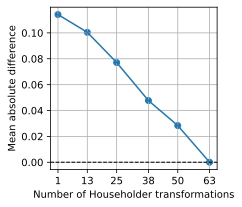

In [836]:
plt.figure(figsize=(3, 3))
plt.plot(Hs, mean_abs_diffs)
plt.scatter(Hs, mean_abs_diffs)
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.grid()
plt.ylabel("Mean absolute difference")
plt.xlabel("Number of Householder transformations")
plt.xticks(Hs)
plt.savefig(f"householder_64by64_seed{seed}.png", dpi=300, bbox_inches='tight')

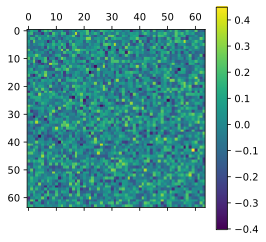

In [805]:
plt.matshow(target, vmin=target.min(), vmax=target.max())
plt.colorbar()
plt.show()

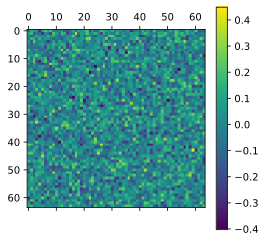

In [806]:
plt.matshow(Q.detach().numpy(), vmin=target.min(), vmax=target.max())
plt.colorbar()
plt.show()

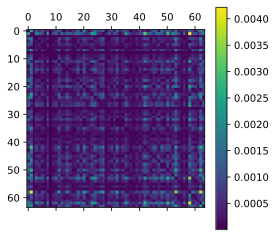

In [807]:
plt.matshow(np.abs(target - Q.detach().numpy()))
plt.colorbar()
plt.show()